In [232]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

użyte technologie

## Zbiór Danych


In [233]:
data = pd.read_csv('smoking.csv', sep=',')

- ID : id osoby
- gender: płeć osoby - 0 kobieta, 1 mężczyzna
- age: grupy w przedziałach 5-letnich
- height(cm) - wzrost w przedziałach 5cm
- weight(kg) - waga w przedziałach 5kg
- waist(cm) : obwód talii w centrymetrach
- eyesight(left): Oznaczone wartością między 0,1-2,5 lub 9,9
- eyesight(right): Oznaczone wartością między 0,1-2,5 lub 9,9
- hearing(left): jakość słuchu ucha osoby (1 - normalne, 2 - nieprawidłowe)
- hearing(right): jakość słuchu ucha osoby (1 - normalne, 2 - nieprawidłowe)
- systolic : ciśnienie krwi
- relaxation : ciśnienie krwi
- fasting blood sugar: poziom cukru na czczo
- Cholesterol : całkowity cholesterol
- triglyceride
- HDL : typ cholesterolu
- LDL : typ cholesterolu
- hemoglobin
- Urine protein: białko moczu
- serum creatinine: kreatyna w surowicy
- AST : typ transaminazy glutaminowej szczawiooctowej
- ALT : typ transaminazy glutaminowej szczawiooctowej
- Gtp : γ-GTP
- oral : Oral Examination status (s whether the examinee accepted the oral examination).
- dental caries: próchnica zębów
- tartar : kamień nażebny
- smoking: czy dana osoba pali (1 - pali, 0 - nie pali)

Text(0.5, 1.0, 'Gender of Patients')

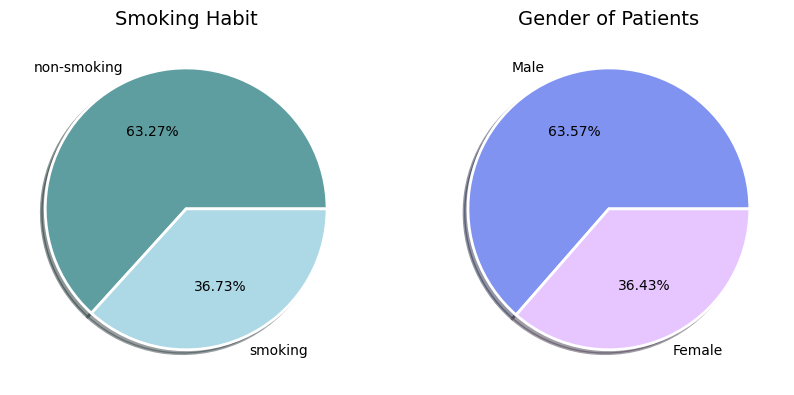

In [234]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.pie(data['smoking'].value_counts(), labels=['non-smoking','smoking'],
        autopct="%1.2f%%", colors = ["#5F9EA0", "#ADD8E6"], 
        wedgeprops=dict(width=1, edgecolor='w',linewidth=2), shadow=True,)
plt.title('Smoking Habit', fontsize=14)


plt.subplot(122)
plt.pie(data['gender'].value_counts(), labels=['Male','Female'],
        autopct="%1.2f%%", colors = ["#8093f1", "#e7c6ff"],
        wedgeprops=dict(width=1, edgecolor='white',linewidth=2), shadow=True,)
plt.title('Gender of Patients', fontsize=14,)

Wykresy pokazują nam procenty badanych jako płci i palących, skala jest nieznaczna(prawie 1:2) w obu przypadkach więc baza danych jest wiarygodna\
\
w przypadku gdy skala byłaby większa (np 1:10 i powyżej) moglibyśmy usunąć nadmiarowe próbki(under-sampling) lub dodać kopie próbek z klasy mniej licznej(over-sampling) w celu zbalansowania zbioru danych

In [235]:
for column_name in data.columns:
    if data[column_name].dtype == object:
        unique_categories = data[column_name].unique()
        print("Feature '{column_name}' has {unique_categories} unique categories".format(column_name=column_name, unique_categories=unique_categories))

data['gender'] = data['gender'].replace(['F', 'M'], [0, 1])
data['tartar'] = data['tartar'].replace(['Y', 'N'], [1, 0])

target_column = ['smoking']
predictors = list(set(list(data.columns))-set(target_column)-set(['ID']))

Feature 'gender' has ['F' 'M'] unique categories
Feature 'oral' has ['Y'] unique categories
Feature 'tartar' has ['Y' 'N'] unique categories


importowanie zbioru danych\
sprawdzenie które kolumny są kategoryczne - gender, oral i tartar\
kategorie kategoryczne zamieniamy na numeryczne:\
w kolumnie 'gender' wartosc F(female) na 0 i M(male) na 1\
w kolumnie 'tartar' Y(yes) na 1 i N(no) na 0\
widzimy, że kolumna 'oral' ma jedną kategorię, dlatego upewnimy się, że nie występują w niej inne wartości\
Zbiór danych dzielimy na kolumne klasyfikującą czy dana osoba jest paląca i na predyktory na podstawie których to stwierdzamy

In [236]:

def check_for_non_y_value(df, column_name):
    column = df[column_name]
    non_y_values = column[column != 'Y']
    if len(non_y_values) > 0:
        return True
    else:
        return False
    
check_for_non_y_value(data, 'oral')



False

Wynik 'false' oznacza, że ta kolumna nie ma innych wartości niz 'Y', co czyni ją zbedną i nie mającą wpływu na klasyfikacje - pomijamy tę kolumnę

In [237]:
data.drop(['oral'], axis=1, inplace=True)
data.drop('ID', axis=1, inplace=True)
predictors.remove('oral')

##### Usuwanie błędnych danych
z bazy danych usuwamy dane odstające(tzw. 'outliers')\
używamy do tego z-score(standardowy wynik)\
dany jest wzorem **_z = (x - srednia)/odchylenie standardowe_**

In [190]:
standard_deviations = 3

data[data.apply(lambda x: np.abs(x - x.mean()) / x.std() < standard_deviations).all(axis=1)]

,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking
0,0,40,155,60,81.3,1.2,1.0,1.0,1.0,114.0,...,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,1,0
1,0,40,160,60,81.0,0.8,0.6,1.0,1.0,119.0,...,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,1,0
2,1,55,170,60,80.0,0.8,0.8,1.0,1.0,138.0,...,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,0,1
4,0,40,155,60,86.0,1.0,1.0,1.0,1.0,120.0,...,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,0,0
5,1,30,180,75,85.0,1.2,1.2,1.0,1.0,128.0,...,129.0,16.2,1.0,1.2,18.0,27.0,33.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55687,0,40,170,65,75.0,0.9,0.9,1.0,1.0,110.0,...,118.0,12.3,1.0,0.6,14.0,7.0,10.0,1,1,0
55688,0,45,160,50,70.0,1.2,1.2,1.0,1.0,101.0,...,79.0,14.0,1.0,0.9,20.0,12.0,14.0,0,1,0
55689,0,55,160,50,68.5,1.0,1.2,1.0,1.0,117.0,...,63.0,12.4,1.0,0.5,17.0,11.0,12.0,0,0,0
55690,1,60,165,60,78.0,0.8,1.0,1.0,1.0,133.0,...,146.0,14.4,1.0,0.7,20.0,19.0,18.0,0,0,0


Sprawdzamy, czy zbiór danych nie posiada żadnych pustych danych:

In [191]:
print(data.isnull().sum())
print(data.isnull().values.any())

gender                 0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
tartar                 0
smoking                0
dtype: int64
False


nie ma żadnych pustych danych, w przeciwnym wypadku albo byśmy takie wiersze usunęli, albo wypełnili brakujące dane medianą z tej kolumny

In [192]:
print(predictors)

dataPredictiors = data[predictors].values
dataTarget = data[target_column].values

print(dataPredictiors[0])


['height(cm)', 'gender', 'fasting blood sugar', 'eyesight(left)', 'hearing(right)', 'tartar', 'relaxation', 'serum creatinine', 'hemoglobin', 'HDL', 'LDL', 'Cholesterol', 'eyesight(right)', 'ALT', 'systolic', 'AST', 'dental caries', 'age', 'weight(kg)', 'waist(cm)', 'hearing(left)', 'Gtp', 'Urine protein', 'triglyceride']
[155.    0.   94.    1.2   1.    1.   73.    0.7  12.9  73.  126.  215.
   1.   19.  114.   18.    0.   40.   60.   81.3   1.   27.    1.   82. ]


## Preprocessing bazy danych

Bazę danych podzielimy na dwie wersje - jedną mniej przetworzoną, i drugą bardziej przetworzoną

In [193]:
less_Processed_data = data.copy()
more_Processed_data = data.copy()

W bazie danych posiadamy kolumny kategoryczne - na nich nie stosujemy normalizacji

In [194]:
columns_to_scale = ['age', 'height(cm)', 'weight(kg)','waist(cm)','eyesight(left)','eyesight(right)',
                    'hearing(left)', 'hearing(right)','systolic','relaxation','fasting blood sugar',
                      'Cholesterol','triglyceride','HDL','LDL','hemoglobin','Urine protein', 'serum creatinine',
                      'AST','ALT','Gtp', ]

mm = MinMaxScaler()

In [195]:
more_Processed_data[columns_to_scale] = mm.fit_transform(more_Processed_data[columns_to_scale])

In [196]:
LPpredictors_train, LPpredictors_test, LPtarget_train, LPtarget_test = train_test_split(less_Processed_data[predictors].values, less_Processed_data[target_column].values, test_size=0.3, random_state=42)

MPpredictors_train, MPpredictors_test, MPtarget_train, MPtarget_test = train_test_split(more_Processed_data[predictors].values, more_Processed_data[target_column].values, test_size=0.3, random_state=42)

# print(LPpredictors_test.shape)

rozdzielenie bazy danych na zbiór treningowy i testowy

W poniższych rozwiązaniach, do rozwiązań użyjemy macierzy błędów. Jak będziemy ją odczytywać?\
\
szablon:\
True positives | False positives\
False negatives | True negatives\
\
Jak to rozumieć? True positives to wartośći gdzie model przewidywał prawdę i to jest prawda\
False positives - model przewidywał prawdę a był to fałsz\
False negatives - model przewidywał fałsz a była to prawda\
True negatives - model przewidywał fałsz i był to fałsz

### Drzewa decyzyjne

In [197]:
LPDTsmaller = DecisionTreeClassifier(max_depth=3)
LPDTBigger = DecisionTreeClassifier()

MPDTsmaller = DecisionTreeClassifier(max_depth=3)
MPDTBigger = DecisionTreeClassifier()

Drzewo decyzyjne dla mniej przerobionej bazy danych

In [198]:
LPDTsmaller.fit(LPpredictors_train, LPtarget_train)
LPDTBigger.fit(LPpredictors_train, LPtarget_train)

LPsmallerPred = LPDTsmaller.predict(LPpredictors_test)
LPbiggerPred = LPDTBigger.predict(LPpredictors_test)

print("accuracy of smaller tree: ", LPDTsmaller.score(LPpredictors_test, LPtarget_test))
print("accuracy of bigger tree: ", LPDTBigger.score(LPpredictors_test, LPtarget_test))

print("accuracy score of smaller tree: ", accuracy_score(LPtarget_test, LPsmallerPred)*100)
print("accuracy score of bigger tree: ", accuracy_score(LPtarget_test, LPbiggerPred)*100)

LPsmallerCM = confusion_matrix(LPtarget_test, LPsmallerPred)

LPbiggerCM = confusion_matrix(LPtarget_test, LPbiggerPred)


accuracy of smaller tree:  0.7219894661240125
accuracy of bigger tree:  0.7695116112042135
accuracy score of smaller tree:  72.19894661240124
accuracy score of bigger tree:  76.95116112042135


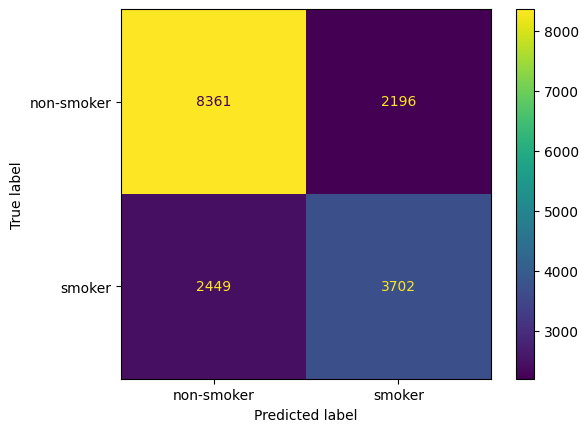

In [238]:
LPdisp = ConfusionMatrixDisplay(confusion_matrix=LPsmallerCM, display_labels=['non-smoker', 'smoker'])
LPdisp.plot()

model pomylił się podobnie dla ilości palących co nie palących (2449 i 2196)

Drzewo decyzyjne dla bardziej przerobionej bazy danych

In [200]:
MPDTsmaller.fit(MPpredictors_train, MPtarget_train)
MPDTBigger.fit(MPpredictors_train, MPtarget_train)

MPsmallerPred = MPDTsmaller.predict(MPpredictors_test)
MPbiggerPred = MPDTBigger.predict(MPpredictors_test)

print("accuracy of smaller tree: ", MPDTsmaller.score(MPpredictors_test, MPtarget_test))
print("accuracy of bigger tree: ", MPDTBigger.score(MPpredictors_test, MPtarget_test))

print("accuracy score of smaller tree: ", accuracy_score(MPtarget_test, MPsmallerPred)*100)
print("accuracy score of bigger tree: ", accuracy_score(MPtarget_test, MPbiggerPred)*100)

MPsmallerCM = confusion_matrix(LPtarget_test, MPsmallerPred)

MPbiggerCM = confusion_matrix(LPtarget_test, MPbiggerPred)

accuracy of smaller tree:  0.7219894661240125
accuracy of bigger tree:  0.7704093847258798
accuracy score of smaller tree:  72.19894661240124
accuracy score of bigger tree:  77.04093847258798


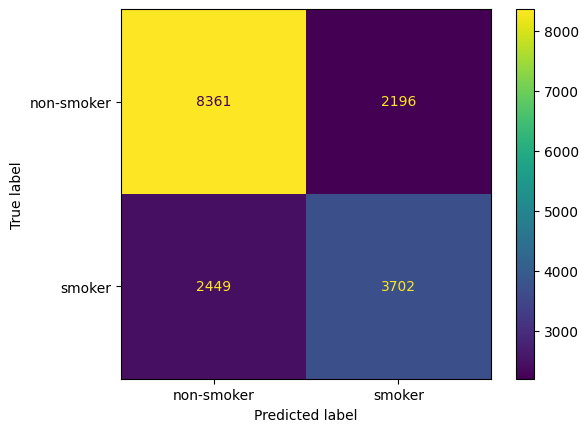

In [239]:
MPdisp = ConfusionMatrixDisplay(confusion_matrix=MPsmallerCM, display_labels=['non-smoker', 'smoker'])
MPdisp.plot()

model pomylił się podobnie do ilości palących jak i nie palących

### Naive-Bayes

Naive-bayes dla mniej przerobionych danych

In [202]:
LPgnb = GaussianNB()
LPgnb_pred = LPgnb.fit(LPpredictors_train, LPtarget_train).predict(LPpredictors_test)
LPgnb.score(LPpredictors_test, LPtarget_test)


d:\Pliki programów\Python\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7049916207804644

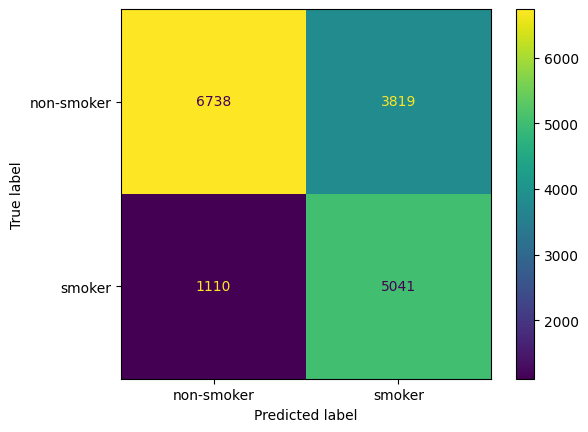

In [240]:
LPnaiveCM = confusion_matrix(LPtarget_test, LPgnb_pred)
LPdispNaive = ConfusionMatrixDisplay(confusion_matrix=LPnaiveCM, display_labels=['non-smoker', 'smoker'])
LPdispNaive.plot()


Model prawie 4 razy bardziej się pomylił co do ilości palących(nie byli palący, 3819) niż do nie palących(byli palący, 1110)

Naive-bayes dla bardziej przetworzonych danych

In [204]:
MPgnb = GaussianNB()
MPgnb_pred = MPgnb.fit(MPpredictors_train, MPtarget_train).predict(MPpredictors_test)
MPgnb.score(MPpredictors_test, MPtarget_test)


d:\Pliki programów\Python\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7049916207804644

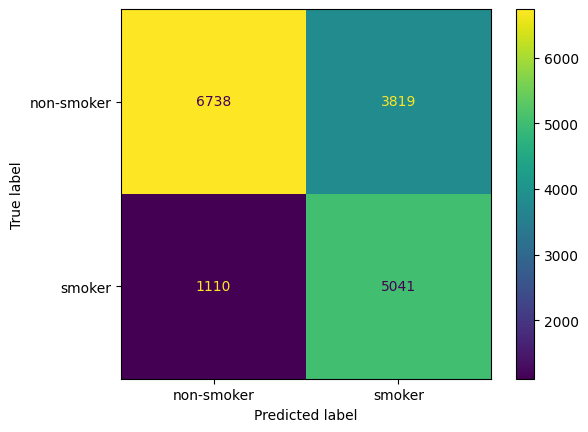

In [241]:
MPnaiveCM = confusion_matrix(MPtarget_test, MPgnb_pred)
MPdispNaive = ConfusionMatrixDisplay(confusion_matrix=MPnaiveCM, display_labels=['non-smoker', 'smoker'])
MPdispNaive.plot()

Model prawie 4 razy bardziej się pomylił co do ilości palących(nie byli palący, 3819) niż do nie palących(byli palący, 1110)

### K-nearest neighbors (k-najbliższych sąsiadów)

K-najbliższych sąsiadów dla mniej przetworzonych danych k=3

In [206]:
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
LPknn_pred = knn.fit(LPpredictors_train, LPtarget_train).predict(LPpredictors_test)
knn.score(LPpredictors_test, LPtarget_test)

d:\Pliki programów\Python\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.6974503231984678

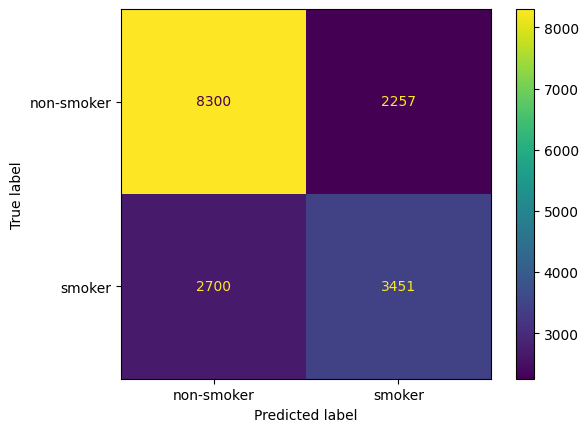

In [242]:
LPknnCM = confusion_matrix(LPtarget_test, LPknn_pred)
LPdispKNN = ConfusionMatrixDisplay(confusion_matrix=LPknnCM, display_labels=['non-smoker', 'smoker'])
LPdispKNN.plot()

model podobnie się pomylił co do palących i nie palących

K-najbliższych sąsiadów dla bardziej przetworzonych danych k=3

In [208]:
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
MPknn_pred = knn.fit(MPpredictors_train, MPtarget_train).predict(MPpredictors_test)
knn.score(MPpredictors_test, MPtarget_test)

d:\Pliki programów\Python\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7347378501316735

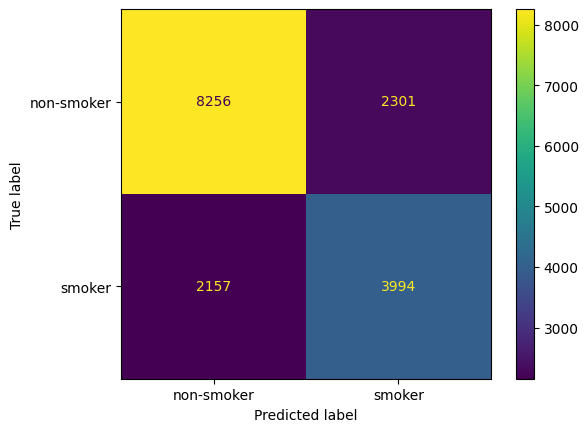

In [243]:
MPknnCM = confusion_matrix(MPtarget_test, MPknn_pred)
MPdispKNN = ConfusionMatrixDisplay(confusion_matrix=MPknnCM, display_labels=['non-smoker', 'smoker'])
MPdispKNN.plot()

model bardzo podobnie się pomylił co do palących i nie palących

K-najbliższych sąsiadów dla mniej przetworzonych danych k=7

In [210]:
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean')
LPknn_pred = knn.fit(LPpredictors_train, LPtarget_train).predict(LPpredictors_test)
knn.score(LPpredictors_test, LPtarget_test)

d:\Pliki programów\Python\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7064280584151305

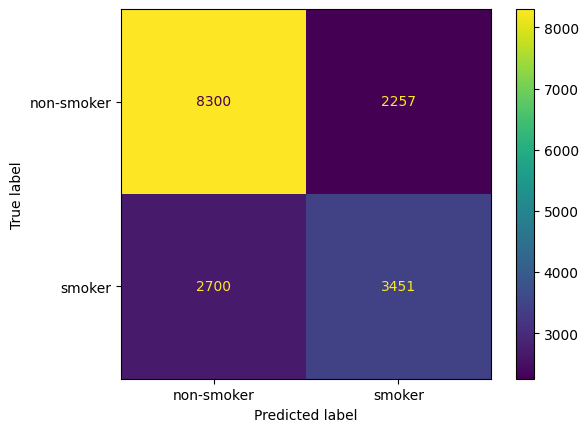

In [244]:
LPknnCM = confusion_matrix(LPtarget_test, LPknn_pred)
LPdispKNN = ConfusionMatrixDisplay(confusion_matrix=LPknnCM, display_labels=['non-smoker', 'smoker'])
LPdispKNN.plot()

model dość podobnie się pomylił co do palących i nie palących

K-najbliższych sąsiadów dla bardziej przetworzonych danych k=7

In [212]:
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean')
MPknn_pred = knn.fit(MPpredictors_train, MPtarget_train).predict(MPpredictors_test)
knn.score(MPpredictors_test, MPtarget_test)

d:\Pliki programów\Python\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7341393344505626

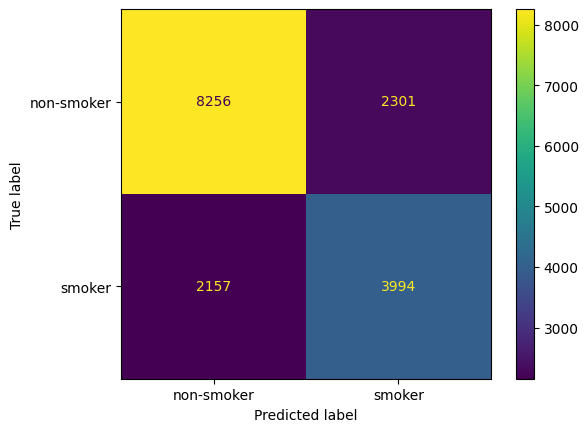

In [245]:
MPknnCM = confusion_matrix(MPtarget_test, MPknn_pred)
MPdispKNN = ConfusionMatrixDisplay(confusion_matrix=MPknnCM, display_labels=['non-smoker', 'smoker'])
MPdispKNN.plot()

model bardzo podobnie się pomylił co do palących i nie palących

K-najbliższych sąsiadów dla mniej przetworzonych danych k=11

In [214]:
knn = KNeighborsClassifier(n_neighbors=11, metric='euclidean')
LPknn_pred = knn.fit(LPpredictors_train, LPtarget_train).predict(LPpredictors_test)
knn.score(LPpredictors_test, LPtarget_test)

d:\Pliki programów\Python\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7033157768733541

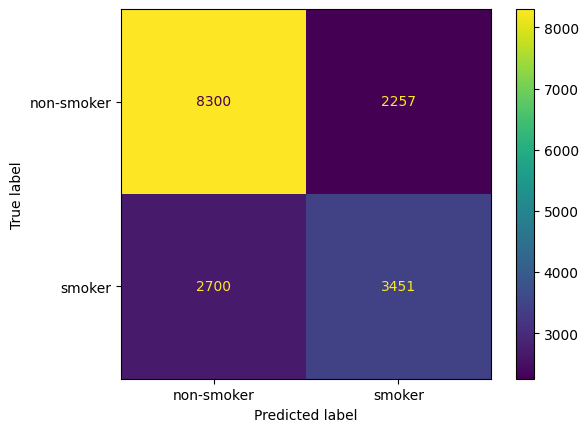

In [246]:
LPknnCM = confusion_matrix(LPtarget_test, LPknn_pred)
LPdispKNN = ConfusionMatrixDisplay(confusion_matrix=LPknnCM, display_labels=['non-smoker', 'smoker'])
LPdispKNN.plot()

model dość podobnie się pomylił co do palących i nie palących

K-najbliższych sąsiadów dla bardziej przetworzonych danych k=11

In [216]:
knn = KNeighborsClassifier(n_neighbors=11, metric='euclidean')
MPknn_pred = knn.fit(MPpredictors_train, MPtarget_train).predict(MPpredictors_test)
knn.score(MPpredictors_test, MPtarget_test)

d:\Pliki programów\Python\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7331817093607853

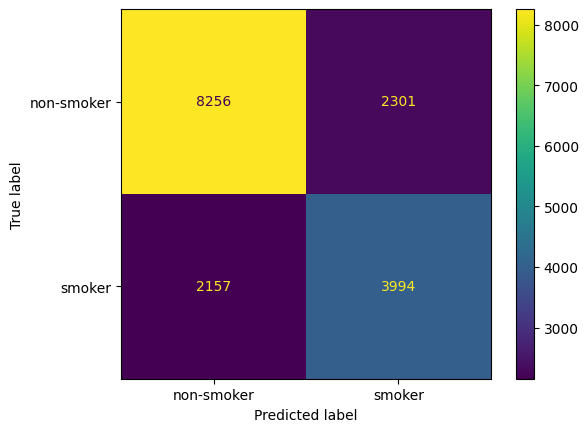

In [247]:
MPknnCM = confusion_matrix(MPtarget_test, MPknn_pred)
MPdispKNN = ConfusionMatrixDisplay(confusion_matrix=MPknnCM, display_labels=['non-smoker', 'smoker'])
MPdispKNN.plot()

model bardzo podobnie się pomylił co do palących i nie palących

### Sieć neuronowa

Sieci neuronowe dla bazy mniej przetworzonej, struktura neuronów 10,10,10, aktywacja relu, solver adam

d:\Pliki programów\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy:  0.7300694278190089


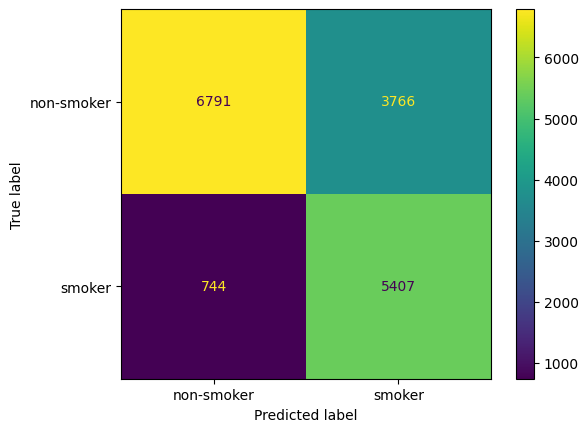

In [248]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=500, activation='relu', solver='adam')

mlp.fit(LPpredictors_train, LPtarget_train)

pred = mlp.predict(LPpredictors_test)

print("accuracy: ", accuracy_score(pred, LPtarget_test))

LPneuronCM = confusion_matrix(LPtarget_test, pred)
LPdispNeuron = ConfusionMatrixDisplay(confusion_matrix=LPneuronCM, display_labels=['non-smoker', 'smoker'])
LPdispNeuron.plot()

model niemal 4 krotnie więcej pomylił wartości palących(3766) co do nie palących(744), trafiona ilość palących(5407) jest dość podobna do trafionej ilości nie palących(6791)

Sieci neuronowe dla bazy bardziej przetworzonej, struktura neuronów 10,10,10, aktywacja relu, solver adam

d:\Pliki programów\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy:  0.7567033756284415


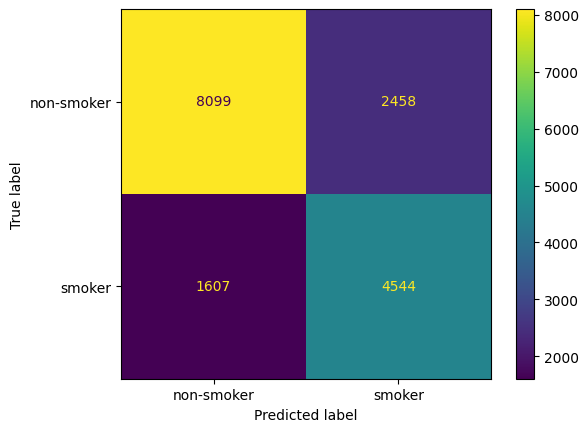

In [249]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=500, activation='relu', solver='adam')

mlp.fit(MPpredictors_train, MPtarget_train)

pred = mlp.predict(MPpredictors_test)

print("accuracy: ", accuracy_score(pred, MPtarget_test))

MPneuronCM = confusion_matrix(MPtarget_test, pred)
MPdispNeuron = ConfusionMatrixDisplay(confusion_matrix=MPneuronCM, display_labels=['non-smoker', 'smoker'])
MPdispNeuron.plot()

model dość dość dobrze sklasyfikował palących(4544) i nie palących(8099)

Sieci neuronowe dla bazy mniej przetworzonej, struktura neuronów 10,5,3, aktywacja tanh, solver sgd

d:\Pliki programów\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy:  0.7066076131194637


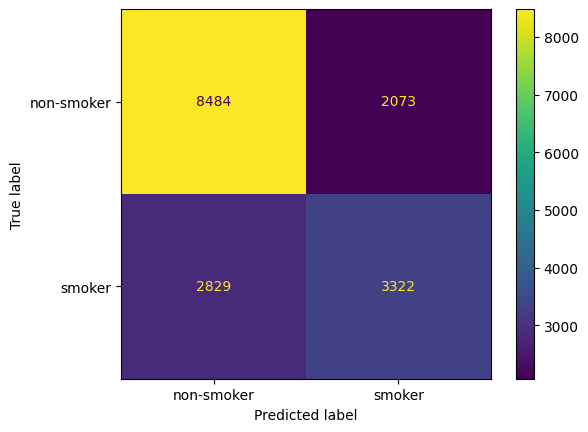

In [250]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5,3), max_iter=500, activation='tanh', solver='sgd')

mlp.fit(LPpredictors_train, LPtarget_train)

pred = mlp.predict(LPpredictors_test)

print("accuracy: ", accuracy_score(pred, LPtarget_test))

LPneuronCM = confusion_matrix(LPtarget_test, pred)
LPdispNeuron = ConfusionMatrixDisplay(confusion_matrix=LPneuronCM, display_labels=['non-smoker', 'smoker'])
LPdispNeuron.plot()

model dość dobrze sklasyfikował nie palących, gorzej wygląda klasyfikacja palących - trafił 3322 i nie trafił 2073 

Sieci neuronowe dla bazy bardziej przetworzonej, struktura neuronów 10,5,3, aktywacja tanh, solver sgd

d:\Pliki programów\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy:  0.7465884606176681


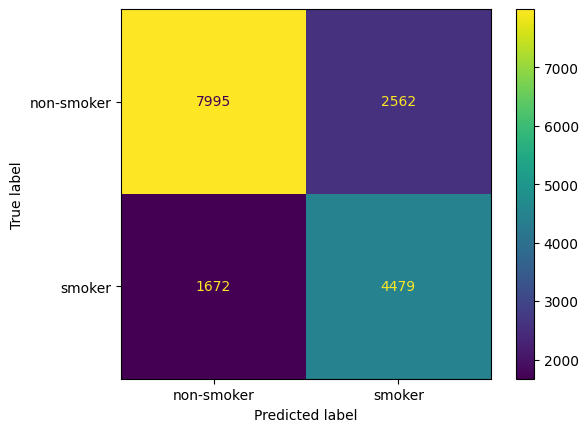

In [251]:
mlp = MLPClassifier(hidden_layer_sizes=(10,5,3), max_iter=500, activation='tanh', solver='sgd')

mlp.fit(MPpredictors_train, MPtarget_train)

pred = mlp.predict(MPpredictors_test)

print("accuracy: ", accuracy_score(pred, MPtarget_test))

MPneuronCM = confusion_matrix(MPtarget_test, pred)
MPdispNeuron = ConfusionMatrixDisplay(confusion_matrix=MPneuronCM, display_labels=['non-smoker', 'smoker'])
MPdispNeuron.plot()

model dość dobrze sklasyfikował nie palących, klasyfikacja osób palących jest akceptowalna - 4479 trafionych na 2562 nietrafionych

Sieci neuronowe dla bazy mniej przetworzonej, struktura neuronów 15,15,10,5 aktywacja logistic, solver adam

d:\Pliki programów\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy:  0.7505985156811108


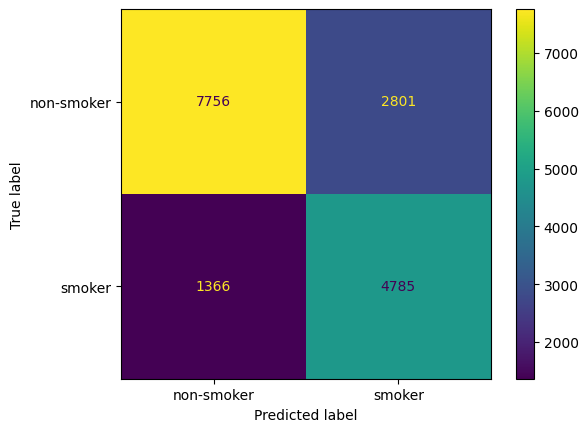

In [252]:
mlp = MLPClassifier(hidden_layer_sizes=(15,15,10,5), max_iter=500, activation='logistic', solver='adam')

mlp.fit(LPpredictors_train, LPtarget_train)

pred = mlp.predict(LPpredictors_test)

print("accuracy: ", accuracy_score(pred, LPtarget_test))

LPneuronCM = confusion_matrix(LPtarget_test, pred)
LPdispNeuron = ConfusionMatrixDisplay(confusion_matrix=LPneuronCM, display_labels=['non-smoker', 'smoker'])
LPdispNeuron.plot()

model dobrze sobie poradził z klasyfikacją niepalących(7756 do 1366), klasyfikacja palących jest akceptowalna(4785 do 2801)

Sieci neuronowe dla bazy bardziej przetworzonej, struktura neuronów 15,15,10,5 aktywacja logistic, solver adam

d:\Pliki programów\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy:  0.755685898970553


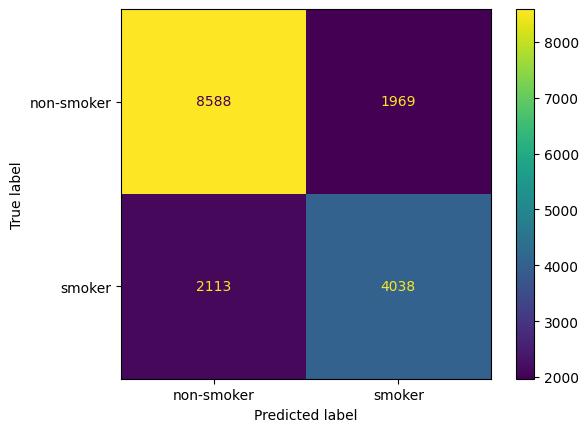

In [253]:
mlp = MLPClassifier(hidden_layer_sizes=(15,15,10,5), max_iter=500, activation='logistic', solver='adam')

mlp.fit(MPpredictors_train, MPtarget_train)

pred = mlp.predict(MPpredictors_test)

print("accuracy: ", accuracy_score(pred, MPtarget_test))

MPneuronCM = confusion_matrix(MPtarget_test, pred)
MPdispNeuron = ConfusionMatrixDisplay(confusion_matrix=MPneuronCM, display_labels=['non-smoker', 'smoker'])
MPdispNeuron.plot()

model sklasyfikował błędnie palących i nie palących z podobnymi ilościami. Dobrze sklasyfikował nie palących, trochę gorzej palących

Sieci neuronowe dla bazy mniej przetworzonej, struktura neuronów 10,10,10 aktywacja logistic, solver lbfgs

d:\Pliki programów\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy:  0.7474263825712234


d:\Pliki programów\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


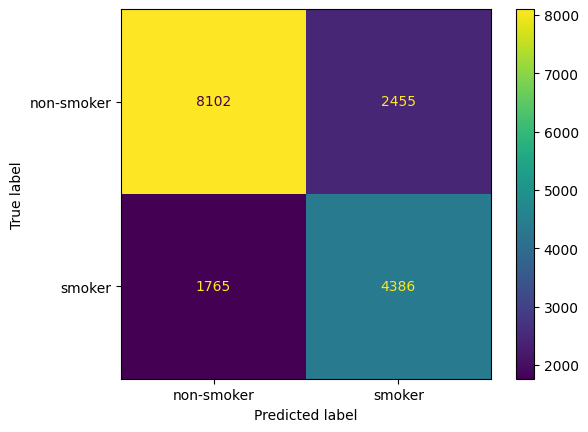

In [254]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=2000, activation='logistic', solver='lbfgs')

mlp.fit(LPpredictors_train, LPtarget_train)

pred = mlp.predict(LPpredictors_test)

print("accuracy: ", accuracy_score(pred, LPtarget_test))

LPneuronCM = confusion_matrix(LPtarget_test, pred)
LPdispNeuron = ConfusionMatrixDisplay(confusion_matrix=LPneuronCM, display_labels=['non-smoker', 'smoker'])
LPdispNeuron.plot()

model dobrze sklasyfikował nie palących(8102 do 1765), gorzej przy palących (4386 do 2455)

Sieci neuronowe dla bazy bardziej przetworzonej, struktura neuronów 10,10,10 aktywacja logistic, solver lbfgs

d:\Pliki programów\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy:  0.7593966961934403


d:\Pliki programów\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


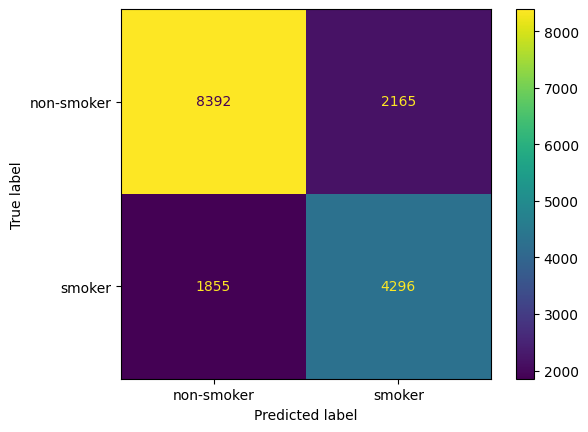

In [255]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=2000, activation='logistic', solver='lbfgs')

mlp.fit(MPpredictors_train, MPtarget_train)

pred = mlp.predict(MPpredictors_test)

print("accuracy: ", accuracy_score(pred, MPtarget_test))

MPneuronCM = confusion_matrix(MPtarget_test, pred)
MPdispNeuron = ConfusionMatrixDisplay(confusion_matrix=MPneuronCM, display_labels=['non-smoker', 'smoker'])
MPdispNeuron.plot()

Model dobrze sklasyfikował nie palących, trochę gorzej lecz akceptowalnie palących

### Podsumowanie

<img src="tabelka.jpg" alt="A local image" title="Optional title" width="1000" height="100" />

Na podstawie wyników zawartych w tabelce, możemy śmiało stwierdzić, że najlepiej poradził sobie klasyfikator drzewa decyzyjnego DTC bez ograniczeń gałęzi. Uzyskał on najwyższy procent trafień zarówno w bazie danych przed normalizacją jak i po. Trochę gorzej ale też dobrze wypadł mlp classifier z róznymi topologiami i konfiguracjami uczenia. Najgorzej natomiast wypadł klasyfikator Naive-Bayes - w tym przypadku normalizacja nie wpływała znacznie na wynik. Patrząc na preprocessing bazy danych, w większości przypadków poprawiał on wyniki, lecz nieznacznie (ok 1%). Natomiast w przypadku klasyfikacji KNN(nieważna ilość sąsiadów do wyboru) i MLP z ukrytymi warstwami neuronów - 10, 5, 3 funkcja aktywacji tanh i solver adam, normalizacja wpłynęła bardzo pozytywnie na wynik - zwiększyła skuteczność od 3 do 5 procent. W większości przypadków modele miały lepszą efektywność przy klasyfikacji osób nie palących niż palących. Może to wynikać z nierówności tych danych(1:2)

## Bibliografia

https://www.jcchouinard.com/confusion-matrix-in-scikit-learn/\
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html\
https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking\
